<a href="https://colab.research.google.com/github/peter-ainsworth/tensorflow_practice/blob/main/02_temperatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural network model for temperature time series

##1. Setup

In [1]:
#Import libraries etc.
import numpy as np
import pandas as pd
#import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
#from dataclasses import dataclass
#from absl import logging
#logging.set_verbosity(logging.ERROR)


##2. Load and inspect data

In [2]:
#Get data
temperatures_df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv")


In [16]:
#Define variables
TEMPS = list(temperatures_df.Temp)
TIMES = list(range(0,len(TEMPS)))
SPLIT = int(0.8*len(TIMES))
TIMES_TRAIN = TIMES[:SPLIT]
TEMPS_TRAIN = TEMPS[:SPLIT]
TIMES_VALID = TIMES[SPLIT:]
TEMPS_VALID = TEMPS[SPLIT:]
WINDOW_SIZE = 64
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

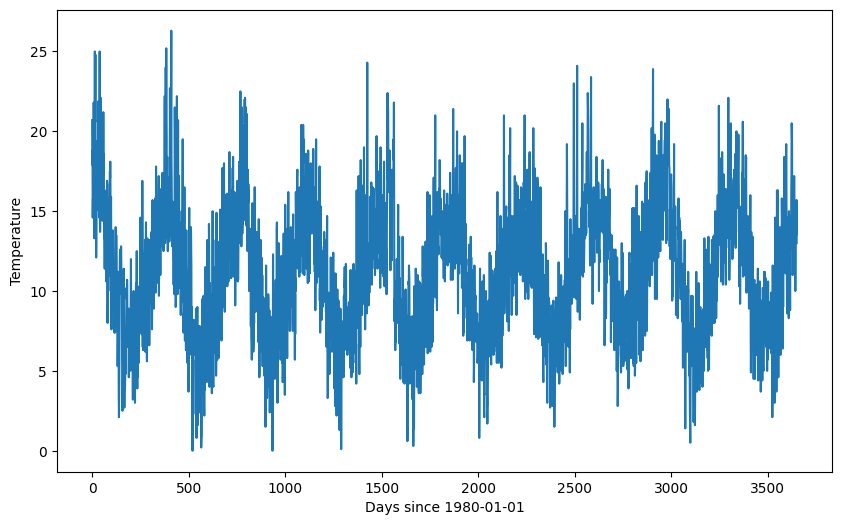

In [36]:
#Define function to plot these data
def plot_temp(times, temps, label=None):
  plt.plot(times, temps, label=label)
  plt.xlabel("Days since 1980-01-01")
  plt.ylabel("Temperature")

#Plot data
plt.figure(figsize=(10, 6))
plot_temp(TIMES, TEMPS)
plt.show()

##3. Preprocessing

In [5]:
#Create windowed training set
ds = tf.data.Dataset.from_tensor_slices(TEMPS_TRAIN)
ds = ds.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE + 1))
ds = ds.shuffle(SHUFFLE_BUFFER_SIZE)
ds = ds.map(lambda w: (w[:-1], w[-1]))
train_set = ds.batch(BATCH_SIZE).prefetch(1)


##4. Create model


In [6]:
#Define model architecture
model = tf.keras.models.Sequential([
              tf.keras.layers.Conv1D(filters=64,
                                       kernel_size=3,
                                       activation="relu",
                                       padding='causal',
                                       input_shape=[None, 1]),
              tf.keras.layers.LSTM(32, return_sequences=True),
              tf.keras.layers.LSTM(32),
              tf.keras.layers.Dense(30, activation="relu"),
              tf.keras.layers.Dense(10, activation="relu"),
              tf.keras.layers.Dense(1)
                                  ])


In [7]:
#Compile model
model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
    metrics=["mse"]
    )


In [8]:
#Fit model
history = model.fit(
    train_set,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
    )

Epoch 1/50
90/90 [==============================] - 14s 73ms/step - loss: 8.5139 - mae: 8.5139
Epoch 2/50
90/90 [==============================] - 6s 64ms/step - loss: 3.2632 - mae: 3.2632
Epoch 3/50
90/90 [==============================] - 6s 64ms/step - loss: 2.8350 - mae: 2.8350
Epoch 4/50
90/90 [==============================] - 7s 78ms/step - loss: 2.2333 - mae: 2.2333
Epoch 5/50
90/90 [==============================] - 6s 67ms/step - loss: 2.1038 - mae: 2.1038
Epoch 6/50
90/90 [==============================] - 6s 64ms/step - loss: 2.0526 - mae: 2.0526
Epoch 7/50
90/90 [==============================] - 7s 78ms/step - loss: 1.9776 - mae: 1.9776
Epoch 8/50
90/90 [==============================] - 6s 65ms/step - loss: 1.9613 - mae: 1.9613
Epoch 9/50
90/90 [==============================] - 7s 77ms/step - loss: 2.0194 - mae: 2.0194
Epoch 10/50
90/90 [==============================] - 7s 75ms/step - loss: 1.9555 - mae: 1.9555
Epoch 11/50
90/90 [==============================] - 6s 64

##5. Use model

In [28]:
#Create windowed dataset
ds = tf.data.Dataset.from_tensor_slices(TEMPS)
ds = ds.window(WINDOW_SIZE, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE))
ds = ds.batch(BATCH_SIZE).prefetch(1)

#Make predictions
predictions = model.predict(ds).squeeze()

#Extract predictions for validation data only
val_predictions = predictions[SPLIT - WINDOW_SIZE:-1]

113/113 [==============================] - 3s 25ms/step


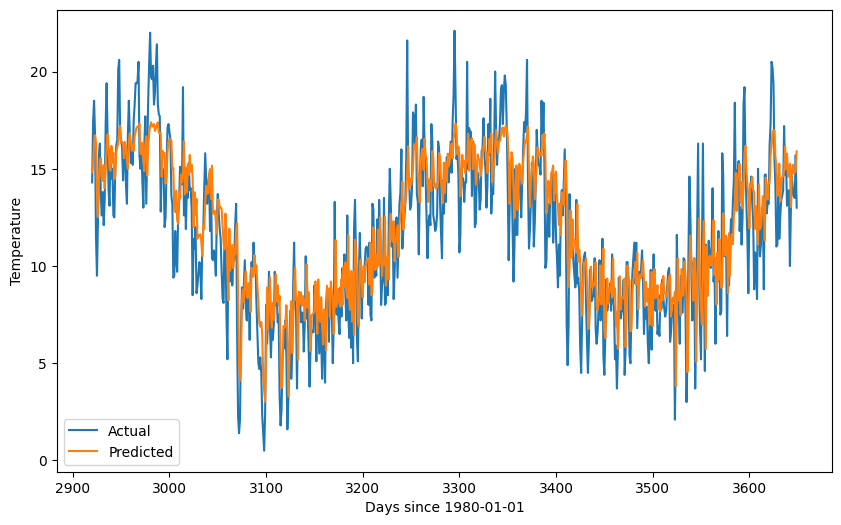

In [37]:
# Plot the predictions
plt.figure(figsize=(10, 6))
plot_temp(TIMES_VALID, TEMPS_VALID, label="Actual")
plot_temp(TIMES_VALID, val_predictions, label="Predicted")
plt.legend()
plt.show()


In [31]:
#Compute metrics
mse = tf.keras.metrics.mean_squared_error(TEMPS_VALID, val_predictions).numpy()
mae = tf.keras.metrics.mean_absolute_error(TEMPS_VALID, val_predictions).numpy()

print(f"mse: {mse:.2f}, mae: {mae:.2f} for validation data")

mse: 5.29, mae: 1.82 for validation data
